## Занятие №1. Основные понятия и шаги при работе с методами искусственного интеллекта.
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

#### План занятия.
1. Основные понятия в области ИИ.
2. Построение модели и процедура оптимизации на простом примере.
3. (Почти) реальная задача по распознаванию изображений.

### Основные понятия

__Объект__ – атомарная сущность в некоторой задаче. Как правило, для объекта необходимо предсказать значение целевой переменной, принадлежность к некоторой группе объектов или же другое свойство.

__Признак__ – величина, описывающая одно из свойств объекта. Например, число (рост), категория (цвет глаз). К признаковому описанию объекта могут быть отнесены и более сложные структуры, например, изображение или запись голоса.

__Задача обучения с учителем, supervised learning problem__ – задача, в которой необходимо предсказать значение __целевой переменной (ответа)__ на новом (ранее не наблюдаемом) объекте. __Для некоторого множества объектов эти значения известны (например, получены с помощью экспертной разметки).__

__Задача регрессии__ – задача обучения с учителем, где целевая переменная является континуальным числом (т.е. принимает континуальное число значений). Например, предсказание ожидаемой зарплаты на основе резюме соискателя. Или же предсказание возраста пользователя интернета на основе его поведения в интернете.

__Задача классификации__ – задача обучения с учителем, где целевая переменная является меткой класса (т.е. может принимать конечное число значений). Например, определение эмоциональной окраски сообщения (позитивная или негативная), или же определение социальной группы, к которой принадлежит клиент банка на основе его трат. Часто разделяют бинарную классификацию (где рассматривается всего два класса, например фрод/не фрод) и мультиклассовую классификацию (где классов может быть конечное число, например пять социальных групп).

__Модель__ (в обучении с учителем) – функция или правило, позволяющая предсказать ответ для любого объекта подходящей структуры (т.е. описываемого теми же признаками, с которыми работает модель). Формально, отображение из пространства объектов в пространство ответов.

__Набор данных, выборка, датасет__  – множество пар объект-ответ (в обучении с учителем), которое используется при настройке параметров (обучении) модели. В обучении без учителя просто множество объектов.

__Задача обучения без учителя, unsupervised learning__ – задача, в которой __нет целевой переменной__ и, как правило, необходимо найти некоторую внутреннюю структуру данных.

In [1]:
# Проверка версий библиотек
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

from torch import nn
import torch.nn.functional as F
import tqdm
from IPython.display import clear_output

print(f'Python version: {sys.version}\n')
print(f'torch version: {torch.__version__}')

Python version: 3.7.7 (default, May  6 2020, 04:59:01) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

torch version: 1.9.0


In [2]:
# Загрузка небольшого файла для третьей части практического занятия
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/PyTorch_seminars/1._Intro_to_DL/input.html -nc

--2021-07-19 11:41:02--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/PyTorch_seminars/1._Intro_to_DL/input.html
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13356 (13K) [text/plain]
Saving to: ‘input.html’

input.html          100%[===================>]  13,04K  --.-KB/s    in 0,001s  

2021-07-19 11:41:02 (10,5 MB/s) - ‘input.html’ saved [13356/13356]



In [3]:
# Для построения графиков на темном фоне раскомментируйте следующую строчку
# plt.style.use('dark_background')

### Простая модель и градиентная оптимизация

Методы искусственного интеллекта опираются на многие результаты человеческой мысли. Одним из столпов существующих достижений является оптимизация: поиск оптимальной (наилучшей) струкруты модели, ее параметров, правил, по которым она работает и др.

В большинстве значимых решений на основе искусственного интеллекта используются [__градиентные методы оптимизации__](https://ru.wikipedia.org/wiki/Градиентные_методы). Т.е. происходит оптимизация некоторого функционала (например, метрики), который зависит от исходных данных и модели некоторым дифференцируемым образом.

Начнем с простой иллюстрации градиентной оптимизации. Похожие механизмы работают при обучении (т.е. настройке) очень сложных моделей, например систем автопилота в автомобилях.

Для примера воспользуемся классическим набором даных о стоимости жилья в Бостоне. Его описание доступно ниже.

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Попробуем использовать только последний признак (`LSTAT – % lower status of the population`) для более наглядной визуализации.

Text(0, 0.5, "Median value of owner-occupied homes in $1000's")

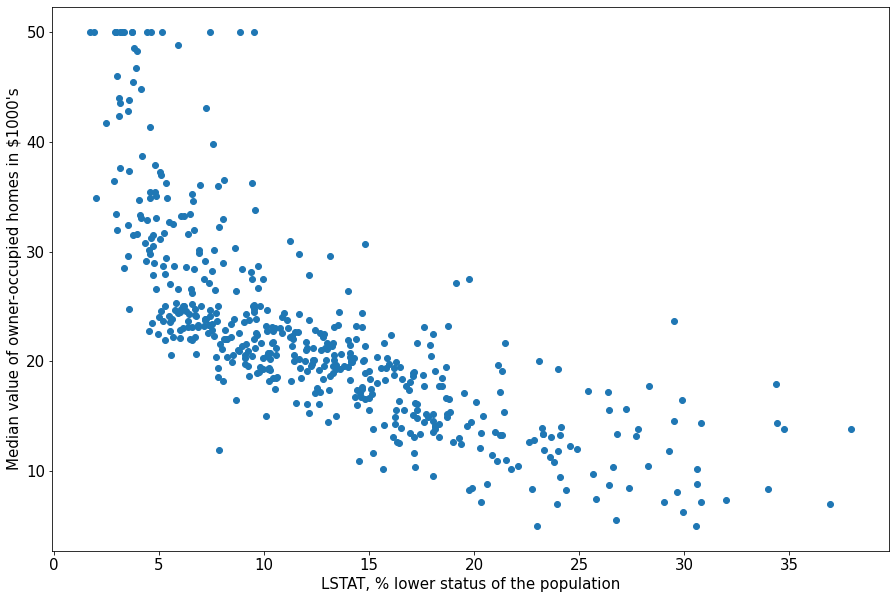

In [5]:
plt.figure(figsize=(15, 10))
plt.scatter(boston.data[:, -1], boston.target)
plt.xlabel('LSTAT, % lower status of the population')
plt.ylabel('Median value of owner-occupied homes in $1000\'s')

In [6]:
# Преобразование данных в формат torch.tensor
x = torch.tensor(boston.data[:,-1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

Попробуем предсказать значение целевой переменной (стоимости жилья) на основе одного признака (LSTAT). Для простоты воспользуемся линейной моделью. В таком случае `w` и `b` будут параметрами (весами) модели (и будут определять наклон прямой и ее сдвиг соответственно). Качество нашей модели будем оценивать, например, при помощи среднеквадратичной ошибки.

Код далее демонстрирует простейшую линейную модель.

In [7]:
# Инициализация параметров модели
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Сама линейная модель
y_pred = w * x + b

# Среднеквадратичная ошибка
loss = torch.mean( (y_pred - y)**2 )

# Подсчет градиента для параметров модели
loss.backward()

In [8]:
loss

tensor(592.1469, grad_fn=<MeanBackward0>)

Посмотрим на градиенты параметров модели:

In [9]:
print("dL/dw = {}\n".format(w.grad))
print("dL/db = {}\n".format(b.grad))

dL/dw = tensor([-47.3514])

dL/db = tensor([-45.0656])



Эти величины указывают, насколько стоит изменить значения параметров, чтобы ошибка стала меньше.

Теперь воспользуемся градиентной оптимизацией для нахождения (суб)-оптимального значения параметров.

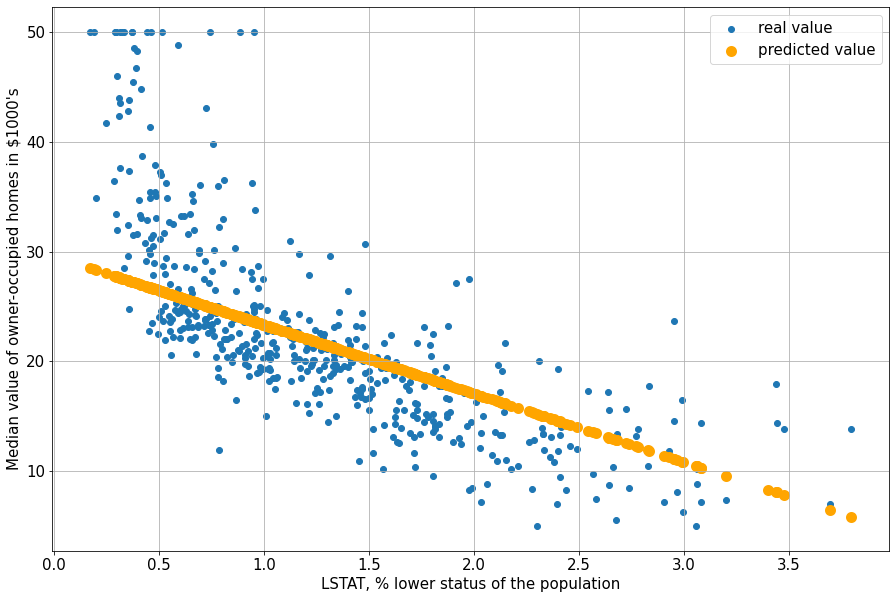

loss =  44.59417


In [10]:
from IPython.display import clear_output

for i in range(100):

    y_pred = w * x + b
    loss = torch.mean( (y_pred - y)**2 )
    loss.backward()

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data
    
    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    # the rest of code is just bells and whistles
    if (i+1)%5==0:
        clear_output(True)
        plt.figure(figsize=(15, 10))
        plt.scatter(x.data.numpy(), y.data.numpy(), label='real value')
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5, label='predicted value')
        plt.grid()
        plt.xlabel('LSTAT, % lower status of the population')
        plt.ylabel('Median value of owner-occupied homes in $1000\'s')
        plt.legend()
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

Как видим, целевая переменная зависит от исходного признака нелинейно. Использование нелинейных преобразований может быть полезным. Но, при этом сама процедура оптимизации не изменяется. Только что мы продемонстрировали это при использовании некоторой нелинейной функции для преобразования признака (например, `torch.log`). Главное, чтобы эта функция была дифференцируемой и не сломала механизм градиентной оптимизации.

Подобным образом происходит настройка параметров (миллионов и даже [сотен миллиардов](https://venturebeat.com/2020/05/29/openai-debuts-gigantic-gpt-3-language-model-with-175-billion-parameters/)) параметров и в более сложных моделях, например, глубоких нейронных сетях. На пример использования нейронной сети и посмотрим далее.

### (Почти) реальная задача
Теперь же обратимся к более сложной задаче. Например, к распознаванию рукописных цифр, и воспользуемся набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). Классификация MNIST – своеобразный "Hello world" в мире компьютерного зрения и машинного обучения в целом, и является классическим примером. Конечно, в настоящий момент подобный набор данных выглядит "игрушечным" (и в научной среде уже не раз упоминалась его излишне простая структура), но своей наглядности и истории он от этого не теряет.

Загрузка и предобработка данных практически полностью сделана за нас. Набор данных состоит из $60000$ черно-белых изображений.

In [11]:
from torchvision.datasets import MNIST

In [12]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

HTTPError: HTTP Error 503: Service Unavailable

In [ ]:
print(f'train dataset size: {len(train_mnist_data)}\ntest dataset size: {len(test_mnist_data)}')

В обучающей выборке `train_mnist_data` содержатся $60000$ примеров, на которые мы будем настраивать параметры нашей модели. Тестовая выборка `test_mnist_data` (содержит $10000$ примеров) будет использоваться для оценки качества итоговой модели.

Рассмотрим данные внимательно:

In [ ]:
print(f'train image shape: {train_mnist_data[0][0].shape}')

In [ ]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')

По факту, каждое черно-белое изображение можно представить в виде матрицы.

In [ ]:
print(f'test image shape: {test_mnist_data[0][0].shape}\ntest dataset size: {len(test_mnist_data)}')

Для решения данной задачи классификации воспользуемся простой нейронной сетью, реализованной с помощью PyTorch. Не будем погружаться в тонкости реализации на данный момент. Если хочется узнать больше прямо сейчас, то всегда можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  Пример документации доступен ниже.

In [ ]:
print(nn.Module.__doc__)

Создадим простейшую нейронную сеть из одного слоя (по факту, это просто логистическая регрессия). На вход будем подавать 784 признака, т.е. значение каждого пикселя изображения. Предсказывать будем ненормированные вероятности для каждого класса (т.е. 10 чисел).

In [ ]:
# Инициализируем класс модели
model = nn.Sequential()

# Добавляем первый слой, отображающий 784 признака (28*28 пикселей) в 10 целевых значений
model.add_module('l1', nn.Linear(784, 128))
model.add_module('relu', nn.ReLU())
model.add_module('l2', nn.Linear(128, 10))

В итоге у нашей модели $7850$ параметров:

In [ ]:
print("Weight shapes:", [w.shape for w in model.parameters()])

In [ ]:
# create dummy data with 32 (`batch_size`) samples and 784 features
x = random_batch[0].reshape(-1, 784)
y = random_batch[1]

# compute outputs given inputs, both are variables
y_predicted = model(x)

plt.pcolormesh(F.softmax(y_predicted[:4], dim=-1).detach()) # display what we've got
plt.colorbar()


В качестве функции ошибки воспользуемся перекрестной энтропией (или кроссэнтропией, как ее принято называть). Она оценивает, насколько предсказанные вероятности принадлежности к тому или иному классу соответствуют истинным (100% верному классу, 0% всем остальным).

In [ ]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(y_predicted, y)

Значение функции ошибки получилось следующим. Нельзя сказать, что оно слишком информативно.

In [ ]:
loss

В широко используемых фреймворках многие операции производятся "под капотом". Например, шаг градиентного спуска (в отличие от кода, который мы использовали выше с предскзаанием цен на недвижимость в Бостоне).

In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)

# Оценка градиента
loss.backward()   
# Шаг градиентного спуска
opt.step()           
# Очистка буфера градиентов ()
opt.zero_grad()

Одна эпоха обучения включает в себя количество шагов, необходимых для покрытия всего датасета (примерно).

In [ ]:
NUM_EPOCHS = 5
history = []
plot_history = []

for epoch in range(NUM_EPOCHS):
    for _i, batch in enumerate(train_data_loader):
        x_batch, y_batch = batch

        # Предсказание модели (логиты, которые можно преобразовать в вероятности)
        y_predicted = model(x_batch.reshape(-1, 784))

        # Вычисление значения функции потерь
        loss = loss_function(y_predicted, y_batch)

        # Вычисление градиентов
        loss.backward()

        # Шаг оптимизации
        opt.step()

        # Очистка буфера градиентов
        opt.zero_grad()

        history.append(loss.item())

        if (_i+50)%100==0:
            clear_output(True)
            plt.figure(figsize=(15, 10))
            plot_history.append(np.mean(history[-100:]))
            plt.plot(plot_history,label='loss')
            plt.yscale('log')
            plt.grid()
            plt.xlabel('Шаг обучения (каждый 100й)')
            plt.ylabel('Значение ошибки (в логарифмическом масштабе)')
            plt.legend()
            plt.show()

Оценим качество нашей модели на тестовой (или же отложенной) выборке. Для этого подсчитаем количество правильно классифицированных цифр.

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Качество распознавания достаточно неплохое. Протестируем на "рукописном" (с помощью мыши/тачпада) вводе.

__Внимание! Следующая часть кода с ручной проверкой модели полезна только для демонстрации. Она не работает в JupyterLab на Google Cloud Platform ввиду ограничений со стороны JupyterLab. Если вы выполняете домашее задание и дошли до этого момента, можете переходить к выводам.__

In [ ]:
from IPython.display import HTML
data = None
HTML(open("input.html").read())

In [ ]:
prepared_data = np.array(data).reshape((28, 28)).astype(np.float32)

# If it fails, just comment the code below
import scipy.ndimage as ndimage
prepared_data = ndimage.gaussian_filter(prepared_data, sigma=(0.5))

In [ ]:
plt.imshow(prepared_data.squeeze())

In [ ]:
transformed_image = torch.FloatTensor(prepared_data.reshape(1, 784))

Ниже можно увидеть вероятности, с которыми модель относит данное изображение к различным классам.

In [ ]:
plt.bar(np.arange(10), F.softmax(model(transformed_image), dim=-1).detach().numpy()[0])
plt.grid()
_ = plt.xticks(range(10))
plt.xlabel('predicted class label')
plt.ylabel('class probability')
_ = plt.title('Model confidence')

In [ ]:
print("This model predicted your input as", model(transformed_image).argmax().item())

Выглядит неплохо. Для получения хороших результатов можно использовать модель с несколькими слоями (лучше сверточными).



В целом, добро пожаловать в мир Искусственного Интеллекта.

Данный пример был достаточно простым, на датасете MNIST не слишком сложно достичь и 100% доли правильных ответов на отложенной выборке.

Если Вы хотите попрактиковаться с более сложным датасетом, Вы можете воспользоваться 
[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Этот датасет полностью аналогичнен MNIST по структуре (и весь код, который использовался для MNIST может быть использован и для FashionMNIST), но в нем представлены изображения различных предметов одежды (кроссовки, футбоки и т.д.).


### Выводы:
* Использование общепринятых терминов делает процесс построения моделей машинного обучения значительно более интуитивным. Также это значительно упрощает диалог со специалистами в области ИИ.
* Для эффективного решения задач стоит ответить на следующие вопросы:
    * С данными какой природы предстоит работать?
    * Как будет измеряться качество?
    * Какую модель/семейство моделей стоит использовать в подобных задачах?
    * Обучающая выборка каких объемов доступна (или необходима)?
* Разобранные примеры описывают основные шаги построения и настройки (обучения) модели. В реальных проектах возникает множество дополнительных задач (например, сбор данных или распределенное обучение моделей), но общая процедура сохраняется.